# Importing modules

In [1]:
# Computing modules
import qutip as qt
import numpy as np
import scipy

# Plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import plasma
from matplotlib.colors import LogNorm, Normalize

# Setting Parameters

In [2]:
lambda_SO = 46e9 #Hz (in case of ground state manifold)
gamma_L = 1.4e9 #Hz/T
gamma_S = 14e9 #Hz/T
B = 0.25 #T (along xz bisector)
Bz = np.sqrt(1/2)*B
Bx = np.sqrt(1/2)*B
d = 1.3e15 #Hz/strain (in case of ground state manifold)
Egx = 0.4*1e-5 #DC strain amplitude
epsilon_Egx = d*Egx

# X Rotation

## Rabi oscillations

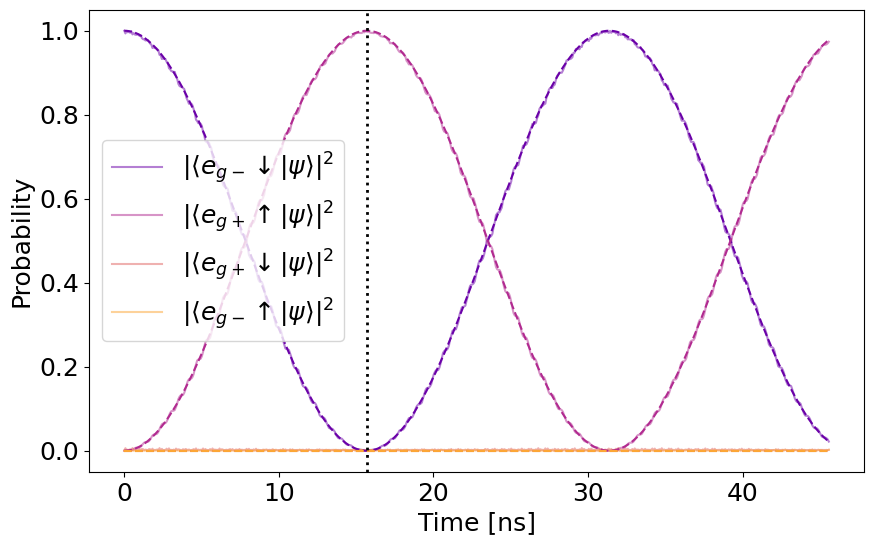

Effective Rabi frequency: 200.27915513411645 MHz


In [3]:
Egx_AC =1.56*1e-6 # AC strain amplitude
epsilon_Egx_AC = d*Egx_AC

psi = (qt.basis(4, 0)).unit() # initial state
phi = np.pi

# Define the system hamiltonian and the drive hamiltonian
H0 = qt.Qobj(np.array([[-lambda_SO/2 - gamma_L*Bz - gamma_S*Bz, 0, epsilon_Egx, gamma_S*Bx],
                      [0, -lambda_SO/2 + gamma_L*Bz + gamma_S*Bz, gamma_S*Bx, epsilon_Egx],
                      [epsilon_Egx, gamma_S*Bx, lambda_SO/2 + gamma_L*Bz - gamma_S*Bz, 0],
                      [gamma_S*Bx, epsilon_Egx, 0, lambda_SO/2 - gamma_L*Bz + gamma_S*Bz]]))

H1 = qt.Qobj(np.array([[0, 0, epsilon_Egx_AC, 0],
                      [0, 0, 0, epsilon_Egx_AC],
                      [epsilon_Egx_AC, 0, 0, 0],
                      [0, epsilon_Egx_AC, 0, 0]]))

def H1_coeff(t, args):
  omega = args['omega']
  phi = args['phi']
  return np.cos(omega * t + phi)

# Find the eigenstates and corresponding eigenenergies of the system hamiltonian
eigenenergies, eigenstates = H0.eigenstates()
omega_0 = eigenenergies[1]-eigenenergies[0]

omega = omega_0

# Diagonalize the system hamiltonian and transform the drive hamiltonian
eigenstates_matrix = qt.Qobj(np.column_stack([state.full() for state in eigenstates]))
diagonalized_H0 = qt.Qobj(np.diag(eigenenergies))

transformed_H1 = eigenstates_matrix.dag() * H1 * eigenstates_matrix

# Solve the system dynamics under drive hamiltonian
t = np.linspace(0,40,600)*2*np.pi/omega_0

H = [diagonalized_H0, [transformed_H1, H1_coeff]]

res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

modulus_0 = []
modulus_1 = []
modulus_2 = []
modulus_3 = []

for state in res.states:
    state_vec = state.full().flatten()

    modulus_0.append(np.abs(state_vec[0])**2)
    modulus_1.append(np.abs(state_vec[1])**2)
    modulus_2.append(np.abs(state_vec[2])**2)
    modulus_3.append(np.abs(state_vec[3])**2)

# Find the corresponding Rabi drive strength
def ideal_rabi(x, rabi_omega_eff):
    return np.cos(rabi_omega_eff * x / 2) ** 2

rabi_omega_eff = 2*gamma_S*Bx*epsilon_Egx_AC / lambda_SO #initial guess

popt, pcov = scipy.optimize.curve_fit(ideal_rabi, t, modulus_0, p0=[2*rabi_omega_eff/(np.pi)])
rabi_omega_eff_optimal = popt[0]

# Plot the results
plt.figure(figsize=(10, 6))
fontsize = 18
plt.plot(t*1e9, modulus_0, color=plasma(0.2), alpha=0.5, label=r"$| \langle e_{g-} \downarrow | \psi \rangle |^2$")
plt.plot(t*1e9, modulus_1, color=plasma(0.4), alpha=0.5, label=r"$| \langle e_{g+} \uparrow | \psi \rangle |^2$")
plt.plot(t*1e9, modulus_2, color=plasma(0.6), alpha=0.5, label=r"$| \langle e_{g+} \downarrow | \psi \rangle |^2$")
plt.plot(t*1e9, modulus_3, color=plasma(0.8), alpha=0.5, label=r"$| \langle e_{g-} \uparrow | \psi \rangle |^2$")
plt.plot(t*1e9, ideal_rabi(t, rabi_omega_eff_optimal), color=plasma(0.2), linestyle='dashed')
plt.plot(t*1e9, 1-ideal_rabi(t, rabi_omega_eff_optimal), color=plasma(0.4), linestyle='dashed')
plt.plot(t*1e9, np.zeros(len(t)), color=plasma(0.6), linestyle='dashed')
plt.plot(t*1e9, np.zeros(len(t)), color=plasma(0.8), linestyle='dashed')
plt.axvline(x=np.pi/rabi_omega_eff_optimal * 1e9, color='k', linestyle=':', linewidth=2)
plt.xlabel("Time [ns]", fontsize = fontsize)
plt.ylabel("Probability", fontsize = fontsize)
#plt.title("Probability Of Each Component Over Time", fontsize = fontsize)
plt.tick_params(labelsize=fontsize)
plt.legend(fontsize = fontsize)

# Save in vector format (e.g., SVG, PDF, or EPS)
plt.savefig("RabiOscillations_Xrot.pdf")   # .svg / .pdf / .eps

plt.show()

print('Effective Rabi frequency: ' + str(rabi_omega_eff_optimal*1e-6) + ' MHz')

## Bloch sphere

In [4]:
states = []

for state in res.states:
    state_vec = state.full().flatten()
    states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

time_pi = np.pi/rabi_omega_eff_optimal
print('Time for Pi rotation: ' + str(time_pi))

index_of_closest_value = np.argmin(np.abs(t - time_pi))

print('Fidelity: ' + str(qt.metrics.fidelity(states[index_of_closest_value], qt.basis(2,1))))

Time for Pi rotation: 1.5686069034423642e-08
Fidelity: 0.9990608358787889


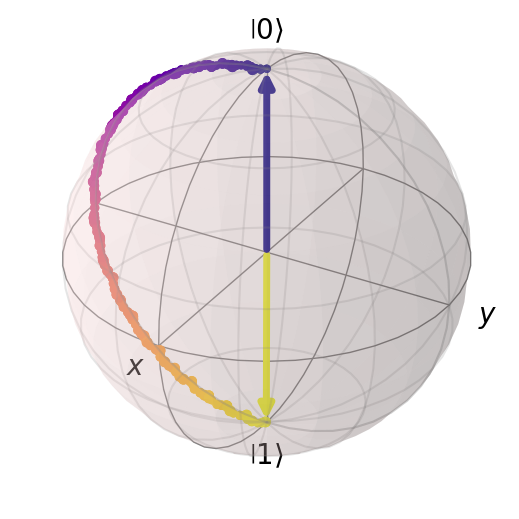

In [5]:
psi = (qt.basis(4,0)).unit() # initial state

t = np.linspace(0,time_pi,200)

H = [diagonalized_H0, [transformed_H1, H1_coeff]]

res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

states = []

for state in res.states:
    state_vec = state.full().flatten()
    states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

states_rotated_frame = []
for i in range(len(states)):
  #states_rotated_frame.append(qt.qip.rz(-omega_0 * t[i]) * res.states[i])
  states_rotated_frame.append((-1/2*1j*omega_0*t[i]*qt.sigmaz()).expm() * states[i])

nrm = Normalize(0, len(states))
colors = plasma(nrm(range(len(states))))

b = qt.Bloch()
b.point_marker = ["o"]
b.point_default_color = colors
for i in range(200):
  b.add_states(states_rotated_frame[i], kind='point')
b.vector_default_color = [colors[0], colors[-1]]
b.vector_width = 5
b.add_states(states[0], kind='vector')
b.add_states(states[-1], kind='vector')
b.show()

# Save in vector format (e.g., SVG, PDF, or EPS)
b.fig.savefig("BlochSphere_Xrot.pdf")   # .svg / .pdf / .eps

## Fidelity

In [6]:
# Sweep the AC strain drive amplitude
Egx_AC_array = np.linspace(5*1e-7, 1.6*1e-6, 250)

# X Rotation
phi = np.pi

rabis = np.zeros(250)

fidelities_0 = np.zeros(250)
fidelities_1 = np.zeros(250)
fidelities_0i1 = np.zeros(250)
fidelities_01 = np.zeros(250)

for index, Egx_AC in enumerate(Egx_AC_array):
  epsilon_Egx_AC = d*Egx_AC

  # Define Hamiltonian
  H0 = qt.Qobj(np.array([[-lambda_SO/2 - gamma_L*Bz - gamma_S*Bz, 0, epsilon_Egx, gamma_S*Bx],
                        [0, -lambda_SO/2 + gamma_L*Bz + gamma_S*Bz, gamma_S*Bx, epsilon_Egx],
                        [epsilon_Egx, gamma_S*Bx, lambda_SO/2 + gamma_L*Bz - gamma_S*Bz, 0],
                        [gamma_S*Bx, epsilon_Egx, 0, lambda_SO/2 - gamma_L*Bz + gamma_S*Bz]]))

  H1 = qt.Qobj(np.array([[0, 0, epsilon_Egx_AC, 0],
                        [0, 0, 0, epsilon_Egx_AC],
                        [epsilon_Egx_AC, 0, 0, 0],
                        [0, epsilon_Egx_AC, 0, 0]]))

  def H1_coeff(t, args):
    omega = args['omega']
    phi = args['phi']
    return np.cos(omega * t + phi)

  # Find the eigenstates and corresponding eigenenergies of the system hamiltonian
  eigenenergies, eigenstates = H0.eigenstates()
  omega_0 = eigenenergies[1]-eigenenergies[0]

  omega = omega_0

  # Diagonalize the system hamiltonian and transform the drive hamiltonian
  eigenstates_matrix = qt.Qobj(np.column_stack([st.full() for st in eigenstates]))
  diagonalized_H0 = qt.Qobj(np.diag(eigenenergies))

  transformed_H1 = eigenstates_matrix.dag() * H1 * eigenstates_matrix

  ### Solve the system dynamics under drive hamiltonian
  t = np.linspace(0,40,600)*2*np.pi/omega_0
  H = [diagonalized_H0, [transformed_H1, H1_coeff]]
    
  ## initial state 1
  psi = (qt.basis(4, 0)).unit()
  
  res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

  modulus_0 = []
  modulus_1 = []
  modulus_2 = []
  modulus_3 = []

  for state in res.states:
      state_vec = state.full().flatten()

      modulus_0.append(np.abs(state_vec[0])**2)
      modulus_1.append(np.abs(state_vec[1])**2)
      modulus_2.append(np.abs(state_vec[2])**2)
      modulus_3.append(np.abs(state_vec[3])**2)

  # Find Rabi drive strength
  def ideal_rabi(x, rabi_omega_eff):
      return np.cos(rabi_omega_eff * x / 2) ** 2

  rabi_omega_eff = 2*gamma_S*Bx*epsilon_Egx_AC / lambda_SO / 2 # initial guess
    
  popt, pcov = scipy.optimize.curve_fit(ideal_rabi, t, modulus_0, p0=[rabi_omega_eff])
  rabi_omega_eff_optimal = popt[0]

  rabis[index] = rabi_omega_eff_optimal

  # Calculate fidelity between ideal pi rotation and strain driven pi rotation
  states = []

  for state in res.states:
      state_vec = state.full().flatten()
      states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

  time_pi = np.pi/rabi_omega_eff_optimal

  index_of_closest_value = np.argmin(np.abs(t - time_pi))

  psi = (qt.basis(4, 0)).unit() # initial state

  t = np.linspace(0,time_pi,1000)

  H = [diagonalized_H0, [transformed_H1, H1_coeff]]

  res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

  states = []

  for state in res.states:
      state_vec = state.full().flatten()
      states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

  states_rotated_frame = []
  for i in range(len(states)):
    states_rotated_frame.append((-1/2*1j*omega_0*t[i]*qt.sigmaz()).expm() * states[i])

  fidelities_0[index] = qt.metrics.fidelity(states_rotated_frame[-1], qt.basis(2,1))

  ## initial state 2
  psi = (qt.basis(4, 1)).unit() # initial state

  res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

  states = []

  for state in res.states:
      state_vec = state.full().flatten()
      states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

  states_rotated_frame = []
  for i in range(len(states)):
    states_rotated_frame.append((-1/2*1j*omega_0*t[i]*qt.sigmaz()).expm() * states[i])

  fidelities_1[index] = qt.metrics.fidelity(states_rotated_frame[-1], qt.basis(2,0))

  ## initial state 3

  psi = (qt.basis(4,0)+qt.basis(4,1)*1j).unit() # initial state

  H = [diagonalized_H0, [transformed_H1, H1_coeff]]

  res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

  states = []

  for state in res.states:
      state_vec = state.full().flatten()
      states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

  states_rotated_frame = []
  for i in range(len(states)):
    states_rotated_frame.append((-1/2*1j*omega_0*t[i]*qt.sigmaz()).expm() * states[i])

  fidelities_0i1[index] = qt.metrics.fidelity(states_rotated_frame[-1], (qt.basis(2,0)-qt.basis(2,1)*1j).unit())

  ## initial state 4
  psi = (qt.basis(4,0)+qt.basis(4,1)).unit() # initial state

  t = np.linspace(0,time_pi,1000)

  H = [diagonalized_H0, [transformed_H1, H1_coeff]]

  res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

  states = []

  for state in res.states:
      state_vec = state.full().flatten()
      states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

  states_rotated_frame = []
  for i in range(len(states)):
    states_rotated_frame.append((-1/2*1j*omega_0*t[i]*qt.sigmaz()).expm() * states[i])

  fidelities_01[index] = qt.metrics.fidelity(states_rotated_frame[-1], (qt.basis(2,0)+qt.basis(2,1)).unit())

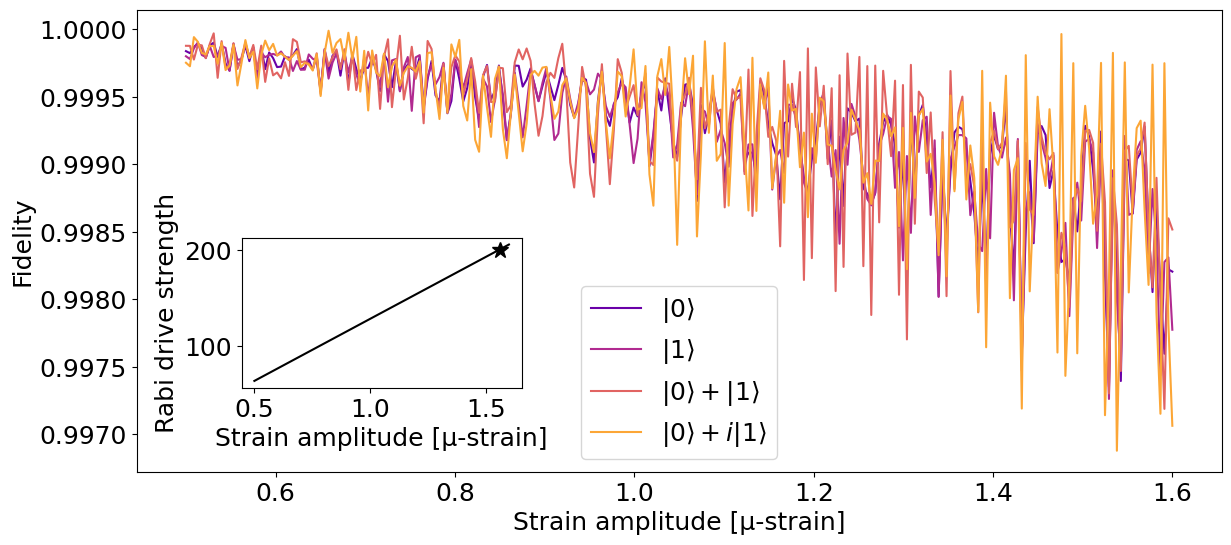

In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

# — Main plot —
ax.plot(Egx_AC_array*1e6, fidelities_0,   label=r'$|0\rangle$', color=plasma(0.2))
ax.plot(Egx_AC_array*1e6, fidelities_1,   label=r'$|1\rangle$', color=plasma(0.4))
ax.plot(Egx_AC_array*1e6, fidelities_01,  label=r'$|0\rangle+|1\rangle$', color=plasma(0.6))
ax.plot(Egx_AC_array*1e6, fidelities_0i1, label=r'$|0\rangle+i|1\rangle$', color=plasma(0.8))

fontsize = 18
ax.set_xlabel("Strain amplitude [μ-strain]", fontsize=fontsize)
ax.set_ylabel("Fidelity",        fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.legend(fontsize=fontsize, loc='lower center')

axins = fig.add_axes([0.2, 0.25, 0.2, 0.25])

axins.plot(Egx_AC_array*1e6, rabis*1e-6, color='k')
axins.plot(1.56, 200, marker='*', color='k', markersize=12)
axins.set_xlabel("Strain amplitude [μ-strain]", fontsize=fontsize)
axins.set_ylabel("Rabi drive strength",  fontsize=fontsize) #Mrad/s
axins.tick_params(labelsize=fontsize)

# Save in vector format (e.g., SVG, PDF, or EPS)
plt.savefig("Fidelity_Xrot.pdf")   # .svg / .pdf / .eps

plt.show()

# Y Rotation

## Rabi oscillations

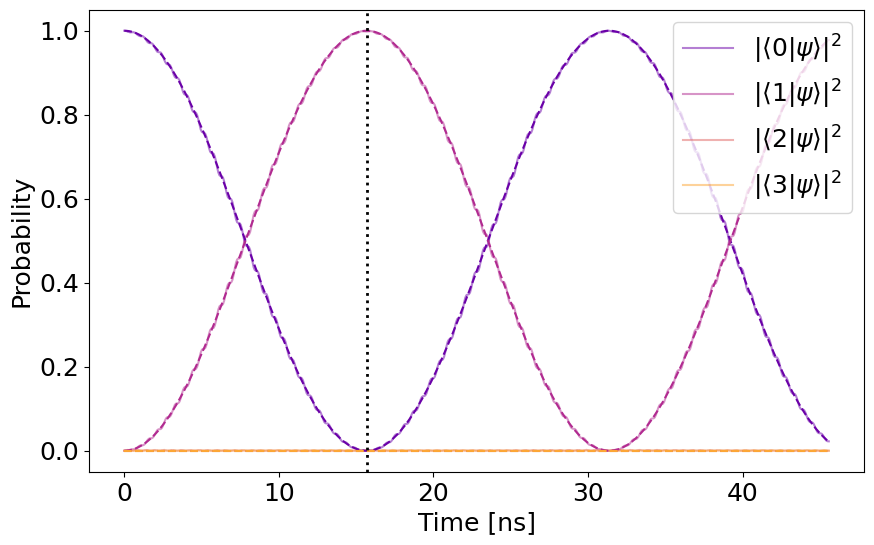

Effective Rabi frequency: 200.31525040660256 MHz


In [24]:
Egx_AC =1.56*1e-6 # AC strain amplitude
epsilon_Egx_AC = d*Egx_AC

psi = (qt.basis(4, 0)).unit() # initial state
phi = np.pi/2

# Define the system hamiltonian and the drive hamiltonian
H0 = qt.Qobj(np.array([[-lambda_SO/2 - gamma_L*Bz - gamma_S*Bz, 0, epsilon_Egx, gamma_S*Bx],
                      [0, -lambda_SO/2 + gamma_L*Bz + gamma_S*Bz, gamma_S*Bx, epsilon_Egx],
                      [epsilon_Egx, gamma_S*Bx, lambda_SO/2 + gamma_L*Bz - gamma_S*Bz, 0],
                      [gamma_S*Bx, epsilon_Egx, 0, lambda_SO/2 - gamma_L*Bz + gamma_S*Bz]]))

H1 = qt.Qobj(np.array([[0, 0, epsilon_Egx_AC, 0],
                      [0, 0, 0, epsilon_Egx_AC],
                      [epsilon_Egx_AC, 0, 0, 0],
                      [0, epsilon_Egx_AC, 0, 0]]))

def H1_coeff(t, args):
  omega = args['omega']
  phi = args['phi']
  return np.cos(omega * t + phi)

# Find the eigenstates and corresponding eigenenergies of the system hamiltonian
eigenenergies, eigenstates = H0.eigenstates()
omega_0 = eigenenergies[1]-eigenenergies[0]

omega = omega_0

# Diagonalize the system hamiltonian and transform the drive hamiltonian
eigenstates_matrix = qt.Qobj(np.column_stack([state.full() for state in eigenstates]))
diagonalized_H0 = qt.Qobj(np.diag(eigenenergies))

transformed_H1 = eigenstates_matrix.dag() * H1 * eigenstates_matrix

# Solve the system dynamics under drive hamiltonian
t = np.linspace(0,40,600)*2*np.pi/omega_0

H = [diagonalized_H0, [transformed_H1, H1_coeff]]

res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

modulus_0 = []
modulus_1 = []
modulus_2 = []
modulus_3 = []

for state in res.states:
    state_vec = state.full().flatten()

    modulus_0.append(np.abs(state_vec[0])**2)
    modulus_1.append(np.abs(state_vec[1])**2)
    modulus_2.append(np.abs(state_vec[2])**2)
    modulus_3.append(np.abs(state_vec[3])**2)

# Find the corresponding Rabi drive strength
def ideal_rabi(x, rabi_omega_eff):
    return np.cos(rabi_omega_eff * x / 2) ** 2

rabi_omega_eff = 2*gamma_S*Bx*epsilon_Egx_AC / lambda_SO #initial guess

popt, pcov = scipy.optimize.curve_fit(ideal_rabi, t, modulus_0, p0=[2*rabi_omega_eff/(np.pi)])
rabi_omega_eff_optimal = popt[0]

# Plot the results
plt.figure(figsize=(10, 6))
fontsize = 18
plt.plot(t*1e9, modulus_0, color=plasma(0.2), alpha=0.5, label=r"$| \langle 0 | \psi \rangle |^2$")
plt.plot(t*1e9, modulus_1, color=plasma(0.4), alpha=0.5, label=r"$| \langle 1 | \psi \rangle |^2$")
plt.plot(t*1e9, modulus_2, color=plasma(0.6), alpha=0.5, label=r"$| \langle 2 | \psi \rangle |^2$")
plt.plot(t*1e9, modulus_3, color=plasma(0.8), alpha=0.5, label=r"$| \langle 3 | \psi \rangle |^2$")
plt.plot(t*1e9, ideal_rabi(t, rabi_omega_eff_optimal), color=plasma(0.2), linestyle='dashed')
plt.plot(t*1e9, 1-ideal_rabi(t, rabi_omega_eff_optimal), color=plasma(0.4), linestyle='dashed')
plt.plot(t*1e9, np.zeros(len(t)), color=plasma(0.6), linestyle='dashed')
plt.plot(t*1e9, np.zeros(len(t)), color=plasma(0.8), linestyle='dashed')
plt.axvline(x=np.pi/rabi_omega_eff_optimal * 1e9, color='k', linestyle=':', linewidth=2)
plt.xlabel("Time [ns]", fontsize = fontsize)
plt.ylabel("Probability", fontsize = fontsize)
#plt.title("Probability Of Each Component Over Time", fontsize = fontsize)
plt.tick_params(labelsize=fontsize)
plt.legend(fontsize = fontsize)

# Save in vector format (e.g., SVG, PDF, or EPS)
plt.savefig("RabiOscillations_Yrot.pdf")   # or .svg / .pdf / .eps

plt.show()

print('Effective Rabi frequency: ' + str(rabi_omega_eff_optimal*1e-6) + ' MHz')

## Bloch sphere

In [25]:
states = []

for state in res.states:
    state_vec = state.full().flatten()
    states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

time_pi = np.pi/rabi_omega_eff_optimal
print('Time for Pi rotation: ' + str(time_pi))

index_of_closest_value = np.argmin(np.abs(t - time_pi))

print('Fidelity: ' + str(qt.metrics.fidelity(states[index_of_closest_value], qt.basis(2,1))))

Time for Pi rotation: 1.5683242525034646e-08
Fidelity: 0.999044583808449


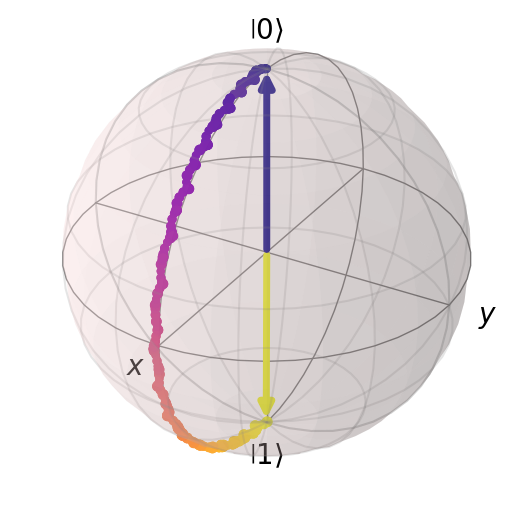

In [10]:
psi = (qt.basis(4,0)).unit() # initial state

t = np.linspace(0,time_pi,200)

H = [diagonalized_H0, [transformed_H1, H1_coeff]]

res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

states = []

for state in res.states:
    state_vec = state.full().flatten()
    states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

states_rotated_frame = []
for i in range(len(states)):
  #states_rotated_frame.append(qt.qip.rz(-omega_0 * t[i]) * res.states[i])
  states_rotated_frame.append((-1/2*1j*omega_0*t[i]*qt.sigmaz()).expm() * states[i])

nrm = Normalize(0, len(states))
colors = plasma(nrm(range(len(states))))

b = qt.Bloch()
b.point_marker = ["o"]
b.point_default_color = colors
for i in range(200):
  b.add_states(states_rotated_frame[i], kind='point')
b.vector_default_color = [colors[0], colors[-1]]
b.vector_width = 5
b.add_states(states[0], kind='vector')
b.add_states(states[-1], kind='vector')
b.show()

# Save in vector format (e.g., SVG, PDF, or EPS)
b.fig.savefig("BlochSphere_Yrot.pdf")   # .svg / .pdf / .eps

## Fidelity

In [11]:
# Sweep the AC strain drive amplitude
Egx_AC_array = np.linspace(5*1e-7, 1.6*1e-6, 250)

# X Rotation
phi = np.pi/2

rabis = np.zeros(250)

fidelities_0 = np.zeros(250)
fidelities_1 = np.zeros(250)
fidelities_0i1 = np.zeros(250)
fidelities_01 = np.zeros(250)

for index, Egx_AC in enumerate(Egx_AC_array):
  epsilon_Egx_AC = d*Egx_AC

  # Define Hamiltonian
  H0 = qt.Qobj(np.array([[-lambda_SO/2 - gamma_L*Bz - gamma_S*Bz, 0, epsilon_Egx, gamma_S*Bx],
                        [0, -lambda_SO/2 + gamma_L*Bz + gamma_S*Bz, gamma_S*Bx, epsilon_Egx],
                        [epsilon_Egx, gamma_S*Bx, lambda_SO/2 + gamma_L*Bz - gamma_S*Bz, 0],
                        [gamma_S*Bx, epsilon_Egx, 0, lambda_SO/2 - gamma_L*Bz + gamma_S*Bz]]))

  H1 = qt.Qobj(np.array([[0, 0, epsilon_Egx_AC, 0],
                        [0, 0, 0, epsilon_Egx_AC],
                        [epsilon_Egx_AC, 0, 0, 0],
                        [0, epsilon_Egx_AC, 0, 0]]))

  def H1_coeff(t, args):
    omega = args['omega']
    phi = args['phi']
    return np.cos(omega * t + phi)

  # Find the eigenstates and corresponding eigenenergies of the system hamiltonian
  eigenenergies, eigenstates = H0.eigenstates()
  omega_0 = eigenenergies[1]-eigenenergies[0]

  omega = omega_0

  # Diagonalize the system hamiltonian and transform the drive hamiltonian
  eigenstates_matrix = qt.Qobj(np.column_stack([st.full() for st in eigenstates]))
  diagonalized_H0 = qt.Qobj(np.diag(eigenenergies))

  transformed_H1 = eigenstates_matrix.dag() * H1 * eigenstates_matrix

  ### Solve the system dynamics under drive hamiltonian
  t = np.linspace(0,40,600)*2*np.pi/omega_0
  H = [diagonalized_H0, [transformed_H1, H1_coeff]]
    
  ## initial state 1
  psi = (qt.basis(4, 0)).unit()
  
  res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

  modulus_0 = []
  modulus_1 = []
  modulus_2 = []
  modulus_3 = []

  for state in res.states:
      state_vec = state.full().flatten()

      modulus_0.append(np.abs(state_vec[0])**2)
      modulus_1.append(np.abs(state_vec[1])**2)
      modulus_2.append(np.abs(state_vec[2])**2)
      modulus_3.append(np.abs(state_vec[3])**2)

  # Find Rabi drive strength
  def ideal_rabi(x, rabi_omega_eff):
      return np.cos(rabi_omega_eff * x / 2) ** 2

  rabi_omega_eff = 2*gamma_S*Bx*epsilon_Egx_AC / lambda_SO / 2 # initial guess
    
  popt, pcov = scipy.optimize.curve_fit(ideal_rabi, t, modulus_0, p0=[rabi_omega_eff])
  rabi_omega_eff_optimal = popt[0]

  rabis[index] = rabi_omega_eff_optimal

  # Calculate fidelity between ideal pi rotation and strain driven pi rotation
  states = []

  for state in res.states:
      state_vec = state.full().flatten()
      states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

  time_pi = np.pi/rabi_omega_eff_optimal

  index_of_closest_value = np.argmin(np.abs(t - time_pi))

  psi = (qt.basis(4, 0)).unit() # initial state

  t = np.linspace(0,time_pi,1000)

  H = [diagonalized_H0, [transformed_H1, H1_coeff]]

  res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

  states = []

  for state in res.states:
      state_vec = state.full().flatten()
      states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

  states_rotated_frame = []
  for i in range(len(states)):
    states_rotated_frame.append((-1/2*1j*omega_0*t[i]*qt.sigmaz()).expm() * states[i])

  fidelities_0[index] = qt.metrics.fidelity(states_rotated_frame[-1], qt.basis(2,1))

  ## initial state 2
  psi = (qt.basis(4, 1)).unit() # initial state

  res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

  states = []

  for state in res.states:
      state_vec = state.full().flatten()
      states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

  states_rotated_frame = []
  for i in range(len(states)):
    states_rotated_frame.append((-1/2*1j*omega_0*t[i]*qt.sigmaz()).expm() * states[i])

  fidelities_1[index] = qt.metrics.fidelity(states_rotated_frame[-1], qt.basis(2,0))

  ## initial state 3

  psi = (qt.basis(4,0)+qt.basis(4,1)*1j).unit() # initial state

  H = [diagonalized_H0, [transformed_H1, H1_coeff]]

  res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

  states = []

  for state in res.states:
      state_vec = state.full().flatten()
      states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

  states_rotated_frame = []
  for i in range(len(states)):
    states_rotated_frame.append((-1/2*1j*omega_0*t[i]*qt.sigmaz()).expm() * states[i])

  fidelities_0i1[index] = qt.metrics.fidelity(states_rotated_frame[-1], (qt.basis(2,0)+qt.basis(2,1)*1j).unit())

  ## initial state 4
  psi = (qt.basis(4,0)+qt.basis(4,1)).unit() # initial state

  t = np.linspace(0,time_pi,1000)

  H = [diagonalized_H0, [transformed_H1, H1_coeff]]

  res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

  states = []

  for state in res.states:
      state_vec = state.full().flatten()
      states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

  states_rotated_frame = []
  for i in range(len(states)):
    states_rotated_frame.append((-1/2*1j*omega_0*t[i]*qt.sigmaz()).expm() * states[i])

  fidelities_01[index] = qt.metrics.fidelity(states_rotated_frame[-1], (qt.basis(2,0)-qt.basis(2,1)).unit())

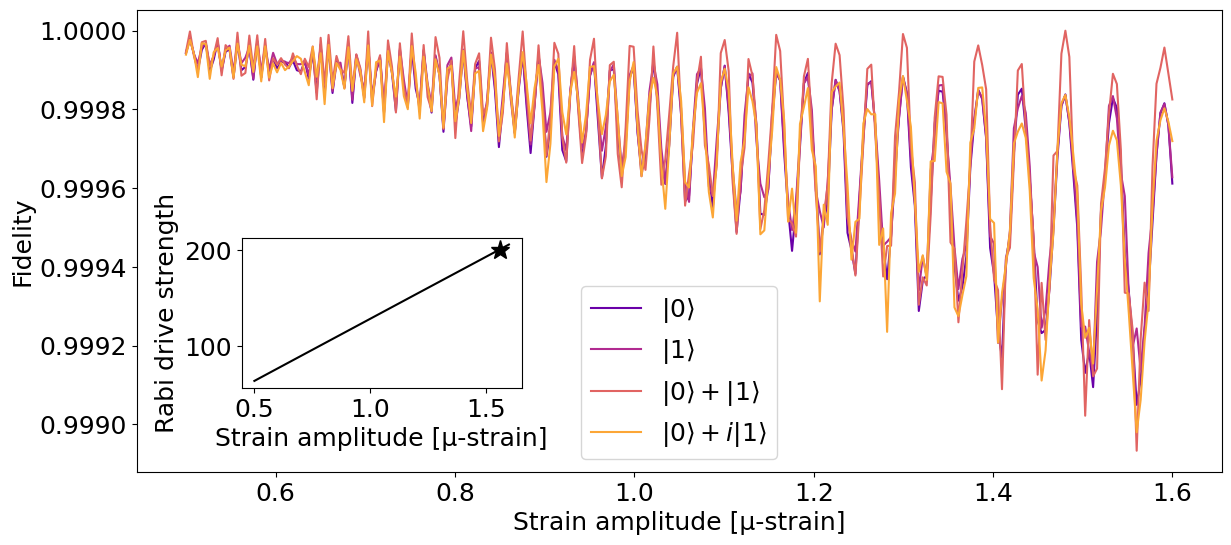

In [12]:
fig, ax = plt.subplots(figsize=(14, 6))

# — Main plot —
ax.plot(Egx_AC_array*1e6, fidelities_0,   label=r'$|0\rangle$', color=plasma(0.2))
ax.plot(Egx_AC_array*1e6, fidelities_1,   label=r'$|1\rangle$', color=plasma(0.4))
ax.plot(Egx_AC_array*1e6, fidelities_01,  label=r'$|0\rangle+|1\rangle$', color=plasma(0.6))
ax.plot(Egx_AC_array*1e6, fidelities_0i1, label=r'$|0\rangle+i|1\rangle$', color=plasma(0.8))

fontsize = 18
ax.set_xlabel("Strain amplitude [μ-strain]", fontsize=fontsize)
ax.set_ylabel("Fidelity",        fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.legend(fontsize=fontsize, loc='lower center')

axins = fig.add_axes([0.2, 0.25, 0.2, 0.25])

axins.plot(Egx_AC_array*1e6, rabis*1e-6, color='k')
axins.plot(1.56, 200, marker='*', color='k', markersize=14)
axins.set_xlabel("Strain amplitude [μ-strain]", fontsize=fontsize)
axins.set_ylabel("Rabi drive strength",  fontsize=fontsize) #Mrad/s
axins.tick_params(labelsize=fontsize)

# Save in vector format (e.g., SVG, PDF, or EPS)
plt.savefig("Fidelity_Yrot.pdf")   # .svg / .pdf / .eps

plt.show()

# XY Bisector Rotation

## Rabi oscillations

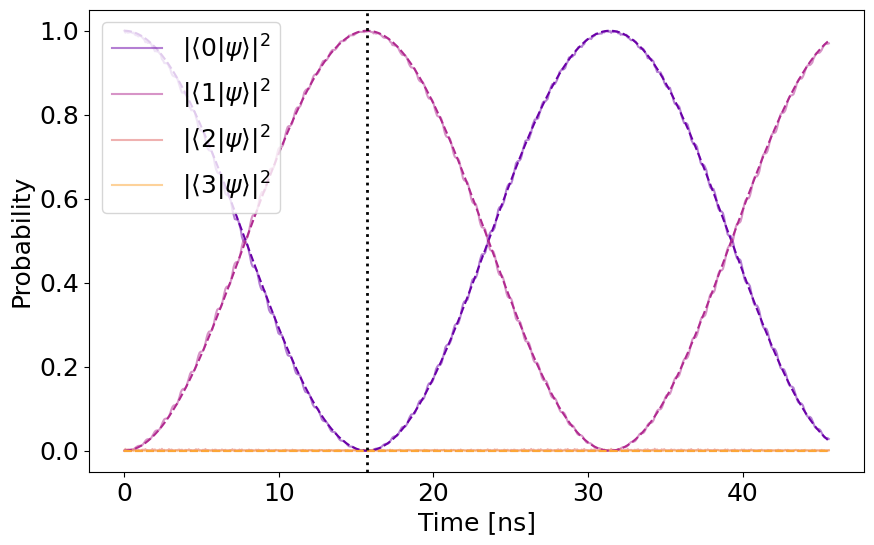

Effective Rabi frequency: 200.00485192635819 MHz


In [28]:
Egx_AC =1.553*1e-6 # AC strain amplitude
epsilon_Egx_AC = d*Egx_AC

psi = (qt.basis(4, 0)).unit() # initial state
phi = 3*np.pi/4

# Define the system hamiltonian and the drive hamiltonian
H0 = qt.Qobj(np.array([[-lambda_SO/2 - gamma_L*Bz - gamma_S*Bz, 0, epsilon_Egx, gamma_S*Bx],
                      [0, -lambda_SO/2 + gamma_L*Bz + gamma_S*Bz, gamma_S*Bx, epsilon_Egx],
                      [epsilon_Egx, gamma_S*Bx, lambda_SO/2 + gamma_L*Bz - gamma_S*Bz, 0],
                      [gamma_S*Bx, epsilon_Egx, 0, lambda_SO/2 - gamma_L*Bz + gamma_S*Bz]]))

H1 = qt.Qobj(np.array([[0, 0, epsilon_Egx_AC, 0],
                      [0, 0, 0, epsilon_Egx_AC],
                      [epsilon_Egx_AC, 0, 0, 0],
                      [0, epsilon_Egx_AC, 0, 0]]))

def H1_coeff(t, args):
  omega = args['omega']
  phi = args['phi']
  return np.cos(omega * t + phi)

# Find the eigenstates and corresponding eigenenergies of the system hamiltonian
eigenenergies, eigenstates = H0.eigenstates()
omega_0 = eigenenergies[1]-eigenenergies[0]

omega = omega_0

# Diagonalize the system hamiltonian and transform the drive hamiltonian
eigenstates_matrix = qt.Qobj(np.column_stack([state.full() for state in eigenstates]))
diagonalized_H0 = qt.Qobj(np.diag(eigenenergies))

transformed_H1 = eigenstates_matrix.dag() * H1 * eigenstates_matrix

# Solve the system dynamics under drive hamiltonian
t = np.linspace(0,40,600)*2*np.pi/omega_0

H = [diagonalized_H0, [transformed_H1, H1_coeff]]

res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

modulus_0 = []
modulus_1 = []
modulus_2 = []
modulus_3 = []

for state in res.states:
    state_vec = state.full().flatten()

    modulus_0.append(np.abs(state_vec[0])**2)
    modulus_1.append(np.abs(state_vec[1])**2)
    modulus_2.append(np.abs(state_vec[2])**2)
    modulus_3.append(np.abs(state_vec[3])**2)

# Find the corresponding Rabi drive strength
def ideal_rabi(x, rabi_omega_eff):
    return np.cos(rabi_omega_eff * x / 2) ** 2

rabi_omega_eff = 2*gamma_S*Bx*epsilon_Egx_AC / lambda_SO #initial guess

popt, pcov = scipy.optimize.curve_fit(ideal_rabi, t, modulus_0, p0=[2*rabi_omega_eff/(np.pi)])
rabi_omega_eff_optimal = popt[0]

# Plot the results
plt.figure(figsize=(10, 6))
fontsize = 18
plt.plot(t*1e9, modulus_0, color=plasma(0.2), alpha=0.5, label=r"$| \langle 0 | \psi \rangle |^2$")
plt.plot(t*1e9, modulus_1, color=plasma(0.4), alpha=0.5, label=r"$| \langle 1 | \psi \rangle |^2$")
plt.plot(t*1e9, modulus_2, color=plasma(0.6), alpha=0.5, label=r"$| \langle 2 | \psi \rangle |^2$")
plt.plot(t*1e9, modulus_3, color=plasma(0.8), alpha=0.5, label=r"$| \langle 3 | \psi \rangle |^2$")
plt.plot(t*1e9, ideal_rabi(t, rabi_omega_eff_optimal), color=plasma(0.2), linestyle='dashed')
plt.plot(t*1e9, 1-ideal_rabi(t, rabi_omega_eff_optimal), color=plasma(0.4), linestyle='dashed')
plt.plot(t*1e9, np.zeros(len(t)), color=plasma(0.6), linestyle='dashed')
plt.plot(t*1e9, np.zeros(len(t)), color=plasma(0.8), linestyle='dashed')
plt.axvline(x=np.pi/rabi_omega_eff_optimal * 1e9, color='k', linestyle=':', linewidth=2)
plt.xlabel("Time [ns]", fontsize = fontsize)
plt.ylabel("Probability", fontsize = fontsize)
#plt.title("Probability Of Each Component Over Time", fontsize = fontsize)
plt.tick_params(labelsize=fontsize)
plt.legend(fontsize = fontsize)

# Save in vector format (e.g., SVG, PDF, or EPS)
plt.savefig("RabiOscillations_XYrot.pdf")   # or .svg / .pdf / .eps

plt.show()

print('Effective Rabi frequency: ' + str(rabi_omega_eff_optimal*1e-6) + ' MHz')

## Bloch sphere

In [29]:
states = []

for state in res.states:
    state_vec = state.full().flatten()
    states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

time_pi = np.pi/rabi_omega_eff_optimal
print('Time for Pi rotation: ' + str(time_pi))

index_of_closest_value = np.argmin(np.abs(t - time_pi))

print('Fidelity: ' + str(qt.metrics.fidelity(states[index_of_closest_value], qt.basis(2,1))))

Time for Pi rotation: 1.570758220778828e-08
Fidelity: 0.9988252053400672


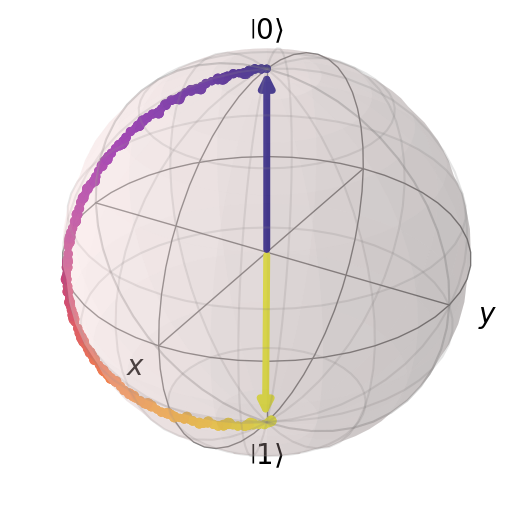

In [20]:
psi = (qt.basis(4,0)).unit() # initial state

t = np.linspace(0,time_pi,200)

H = [diagonalized_H0, [transformed_H1, H1_coeff]]

res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

states = []

for state in res.states:
    state_vec = state.full().flatten()
    states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

states_rotated_frame = []
for i in range(len(states)):
  #states_rotated_frame.append(qt.qip.rz(-omega_0 * t[i]) * res.states[i])
  states_rotated_frame.append((-1/2*1j*omega_0*t[i]*qt.sigmaz()).expm() * states[i])

nrm = Normalize(0, len(states))
colors = plasma(nrm(range(len(states))))

b = qt.Bloch()
b.point_marker = ["o"]
b.point_default_color = colors
for i in range(200):
  b.add_states(states_rotated_frame[i], kind='point')
b.vector_default_color = [colors[0], colors[-1]]
b.vector_width = 5
b.add_states(states[0], kind='vector')
b.add_states(states[-1], kind='vector')
b.show()

# Save in vector format (e.g., SVG, PDF, or EPS)
b.fig.savefig("BlochSphere_XYrot.pdf")   # .svg / .pdf / .eps

## Fidelity

In [21]:
# Sweep the AC strain drive amplitude
Egx_AC_array = np.linspace(5*1e-7, 1.6*1e-6, 250)

# X Rotation
phi = 3*np.pi/4

rabis = np.zeros(250)

fidelities_0 = np.zeros(250)
fidelities_1 = np.zeros(250)
fidelities_0i1 = np.zeros(250)
fidelities_01 = np.zeros(250)

for index, Egx_AC in enumerate(Egx_AC_array):
  epsilon_Egx_AC = d*Egx_AC

  # Define Hamiltonian
  H0 = qt.Qobj(np.array([[-lambda_SO/2 - gamma_L*Bz - gamma_S*Bz, 0, epsilon_Egx, gamma_S*Bx],
                        [0, -lambda_SO/2 + gamma_L*Bz + gamma_S*Bz, gamma_S*Bx, epsilon_Egx],
                        [epsilon_Egx, gamma_S*Bx, lambda_SO/2 + gamma_L*Bz - gamma_S*Bz, 0],
                        [gamma_S*Bx, epsilon_Egx, 0, lambda_SO/2 - gamma_L*Bz + gamma_S*Bz]]))

  H1 = qt.Qobj(np.array([[0, 0, epsilon_Egx_AC, 0],
                        [0, 0, 0, epsilon_Egx_AC],
                        [epsilon_Egx_AC, 0, 0, 0],
                        [0, epsilon_Egx_AC, 0, 0]]))

  def H1_coeff(t, args):
    omega = args['omega']
    phi = args['phi']
    return np.cos(omega * t + phi)

  # Find the eigenstates and corresponding eigenenergies of the system hamiltonian
  eigenenergies, eigenstates = H0.eigenstates()
  omega_0 = eigenenergies[1]-eigenenergies[0]

  omega = omega_0

  # Diagonalize the system hamiltonian and transform the drive hamiltonian
  eigenstates_matrix = qt.Qobj(np.column_stack([st.full() for st in eigenstates]))
  diagonalized_H0 = qt.Qobj(np.diag(eigenenergies))

  transformed_H1 = eigenstates_matrix.dag() * H1 * eigenstates_matrix

  ### Solve the system dynamics under drive hamiltonian
  t = np.linspace(0,40,600)*2*np.pi/omega_0
  H = [diagonalized_H0, [transformed_H1, H1_coeff]]
    
  ## initial state 1
  psi = (qt.basis(4, 0)).unit()
  
  res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

  modulus_0 = []
  modulus_1 = []
  modulus_2 = []
  modulus_3 = []

  for state in res.states:
      state_vec = state.full().flatten()

      modulus_0.append(np.abs(state_vec[0])**2)
      modulus_1.append(np.abs(state_vec[1])**2)
      modulus_2.append(np.abs(state_vec[2])**2)
      modulus_3.append(np.abs(state_vec[3])**2)

  # Find Rabi drive strength
  def ideal_rabi(x, rabi_omega_eff):
      return np.cos(rabi_omega_eff * x / 2) ** 2

  rabi_omega_eff = 2*gamma_S*Bx*epsilon_Egx_AC / lambda_SO / 2 # initial guess
    
  popt, pcov = scipy.optimize.curve_fit(ideal_rabi, t, modulus_0, p0=[rabi_omega_eff])
  rabi_omega_eff_optimal = popt[0]

  rabis[index] = rabi_omega_eff_optimal

  # Calculate fidelity between ideal pi rotation and strain driven pi rotation
  states = []

  for state in res.states:
      state_vec = state.full().flatten()
      states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

  time_pi = np.pi/rabi_omega_eff_optimal

  index_of_closest_value = np.argmin(np.abs(t - time_pi))

  psi = (qt.basis(4, 0)).unit() # initial state

  t = np.linspace(0,time_pi,1000)

  H = [diagonalized_H0, [transformed_H1, H1_coeff]]

  res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

  states = []

  for state in res.states:
      state_vec = state.full().flatten()
      states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

  states_rotated_frame = []
  for i in range(len(states)):
    states_rotated_frame.append((-1/2*1j*omega_0*t[i]*qt.sigmaz()).expm() * states[i])

  fidelities_0[index] = qt.metrics.fidelity(states_rotated_frame[-1], qt.basis(2,1))

  ## initial state 2
  psi = (qt.basis(4, 1)).unit() # initial state

  res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

  states = []

  for state in res.states:
      state_vec = state.full().flatten()
      states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

  states_rotated_frame = []
  for i in range(len(states)):
    states_rotated_frame.append((-1/2*1j*omega_0*t[i]*qt.sigmaz()).expm() * states[i])

  fidelities_1[index] = qt.metrics.fidelity(states_rotated_frame[-1], qt.basis(2,0))

  ## initial state 3

  psi = (qt.basis(4,0)+qt.basis(4,1)*1j).unit() # initial state

  H = [diagonalized_H0, [transformed_H1, H1_coeff]]

  res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

  states = []

  for state in res.states:
      state_vec = state.full().flatten()
      states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

  states_rotated_frame = []
  for i in range(len(states)):
    states_rotated_frame.append((-1/2*1j*omega_0*t[i]*qt.sigmaz()).expm() * states[i])

  fidelities_0i1[index] = qt.metrics.fidelity(states_rotated_frame[-1], (qt.basis(2,0)+qt.basis(2,1)).unit())

  ## initial state 4
  psi = (qt.basis(4,0)+qt.basis(4,1)).unit() # initial state

  t = np.linspace(0,time_pi,1000)

  H = [diagonalized_H0, [transformed_H1, H1_coeff]]

  res = qt.mesolve(H, psi, t, [], args={'omega': omega, 'phi': phi})

  states = []

  for state in res.states:
      state_vec = state.full().flatten()
      states.append(qt.Qobj([[state_vec[0]], [state_vec[1]]]))

  states_rotated_frame = []
  for i in range(len(states)):
    states_rotated_frame.append((-1/2*1j*omega_0*t[i]*qt.sigmaz()).expm() * states[i])

  fidelities_01[index] = qt.metrics.fidelity(states_rotated_frame[-1], (qt.basis(2,0)+qt.basis(2,1)*1j).unit())

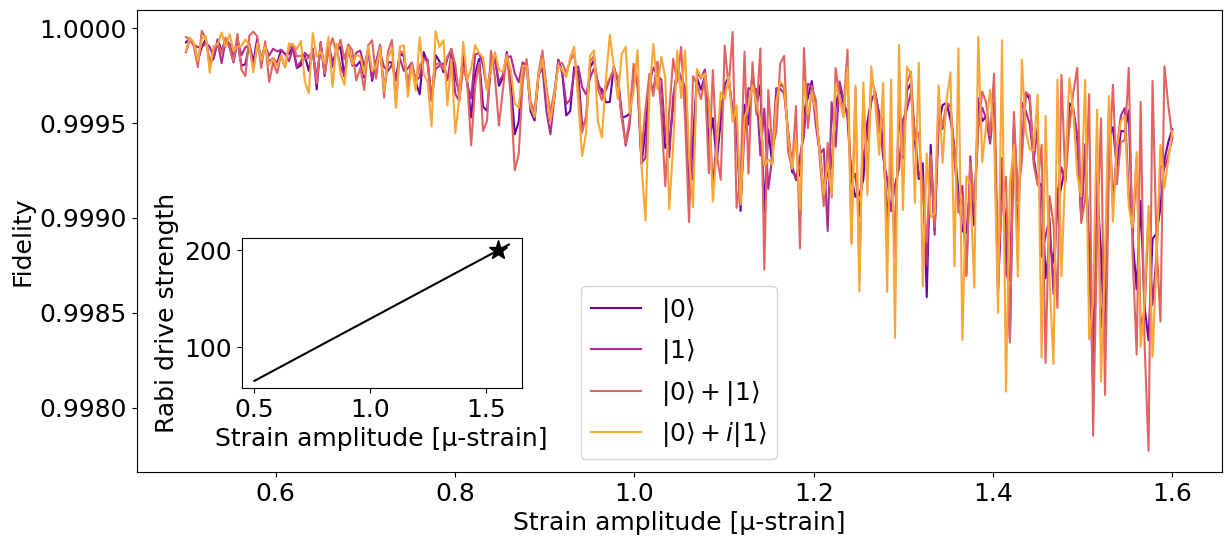

In [22]:
fig, ax = plt.subplots(figsize=(14, 6))

# — Main plot —
ax.plot(Egx_AC_array*1e6, fidelities_0,   label=r'$|0\rangle$', color=plasma(0.2))
ax.plot(Egx_AC_array*1e6, fidelities_1,   label=r'$|1\rangle$', color=plasma(0.4))
ax.plot(Egx_AC_array*1e6, fidelities_01,  label=r'$|0\rangle+|1\rangle$', color=plasma(0.6))
ax.plot(Egx_AC_array*1e6, fidelities_0i1, label=r'$|0\rangle+i|1\rangle$', color=plasma(0.8))

fontsize = 18
ax.set_xlabel("Strain amplitude [μ-strain]", fontsize=fontsize)
ax.set_ylabel("Fidelity",        fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.legend(fontsize=fontsize, loc='lower center')

axins = fig.add_axes([0.2, 0.25, 0.2, 0.25])

axins.plot(Egx_AC_array*1e6, rabis*1e-6, color='k')
axins.plot(1.553, 200, marker='*', color='k', markersize=14)
axins.set_xlabel("Strain amplitude [μ-strain]", fontsize=fontsize)
axins.set_ylabel("Rabi drive strength",  fontsize=fontsize) #Mrad/s
axins.tick_params(labelsize=fontsize)

# Save in vector format (e.g., SVG, PDF, or EPS)
plt.savefig("Fidelity_XYrot.pdf")   # .svg / .pdf / .eps

plt.show()